In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../../src/scenes/')
import syndiff as sd 

from copy import deepcopy
from scipy.ndimage import rotate
import matplotlib.patches as patches
from matplotlib.path import Path

from scipy.optimize import minimize
from astropy.stats import sigma_clipped_stats
from glob import glob
from correct_saturation import saturated_stars, _get_bsc, SkyCoord, image2counts, query_ps1
from astropy.io import fits
from astropy.wcs import WCS
import tessreduce as tr
from PRF import TESS_PRF

from photutils.aperture import CircularAperture, CircularAnnulus,RectangularAperture
from photutils.aperture import ApertureStats, aperture_photometry

from correct_saturation import ps_psf, psf_minimizer, minimize,PS1_to_TESS_mag
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting

In [2]:
tess_filename = '../data/tess2019360165923-s0020-1-1-0165-s_ffic.fits'
tess_hdu = fits.open(tess_filename)
tess_wcs = WCS(tess_hdu[1].header)
tess_data = tess_hdu[1].data

t_y, t_x = np.shape(tess_data)
ty, tx = np.mgrid[:t_y, :t_x]
ty = ty.ravel().astype(int)
tx = tx.ravel().astype(int)

ps1_files = glob('../data/ps1_skycell/*.039*.unconv.satcor.fits')

ps1_assignment = np.load('../PS1_to_TESS/test_assignment.npy').astype(int)

In [3]:
ra,dec = tess_wcs.all_pix2world(964,959,0)

In [4]:
ps1 = {}
cor = []
for file in ps1_files:
    hdu = fits.open(file)
    header = hdu[0].header

    data = image2counts(hdu[0].data,header)
    m,med,std = sigma_clipped_stats(data)
    ps1[file.split('stk.')[1].split('.unconv')[0]] = data-med
    cor += [header['FLUXFACT']]
cor = np.array(cor)
ps1_wcs = WCS(header)

In [5]:
cat = query_ps1(ra,dec,0.4)
px,py = ps1_wcs.all_world2pix(cat.raMean,cat.decMean,0)
cat['ps1x'] = px; cat['ps1y'] = py
_tx,_ty = tess_wcs.all_world2pix(cat.raMean,cat.decMean,0)
cat['tessx'] = _tx; cat['tessy'] = _ty
cat = PS1_to_TESS_mag(cat)

In [6]:
size = 2000
y, x = np.mgrid[:size, :size]
x = x - size/2; y = y - size/2
psfg = models.Gaussian2D(x_stddev=80,y_stddev=80)
psfg = psfg(x,y)
psfg /= np.nansum(psfg)

In [7]:
conv = deepcopy(ps1)
for key in list(ps1.keys()):
    conv[key][np.isnan(conv[key])] = 0
    conv[key] = sd.signal.fftconvolve(conv[key], psfg, mode='same')

ps1_tess = 0.238*conv['r'] + 0.344*conv['i'] + 0.283*conv['z'] + 0.135*conv['y']
noconvps1_tess = 0.238*ps1['r'] + 0.344*ps1['i'] + 0.283*ps1['z'] + 0.135*ps1['y']

In [9]:
assigned_tess = np.unique(ps1_assignment).astype(int)[1:]


In [15]:
np.ones_like(ps1_tess,dtype=int) * assigned_tess[5]

array([[1957513, 1957513, 1957513, ..., 1957513, 1957513, 1957513],
       [1957513, 1957513, 1957513, ..., 1957513, 1957513, 1957513],
       [1957513, 1957513, 1957513, ..., 1957513, 1957513, 1957513],
       ...,
       [1957513, 1957513, 1957513, ..., 1957513, 1957513, 1957513],
       [1957513, 1957513, 1957513, ..., 1957513, 1957513, 1957513],
       [1957513, 1957513, 1957513, ..., 1957513, 1957513, 1957513]])

In [24]:
i= (ps1_assignment == (np.ones_like(ps1_tess,dtype=int) * assigned_tess[5]))

In [25]:
ps1_tess[i]

array([ 8.2712162 ,  8.39674451,  8.52340857, ..., 10.4986794 ,
       10.67555741, 10.60147643])

In [16]:
np.sum(ps1_tess[ps1_assignment &  (np.ones_like(ps1_tess,dtype=int) * assigned_tess[5])])

IndexError: index 7817 is out of bounds for axis 0 with size 6289

In [28]:
ind = assigned_tess[1]

test = ps1_tess[ps1_assignment == ind]
test2 = np.sum(test)
print(len(test))
print(test2)

scene[ty[ind],tx[ind]] = test2
print(scene[ty[ind],tx[ind]])


scene = np.zeros_like(tess_data)

5617
-4664.2189442614235
-4664.2188


In [33]:
import time

start = time.time()

# print(len(assigned_tess))

# ind = assigned_tess[100]

# t = np.argwhere(ps1_assignment==ind)
# print(len(t))
# tt = np.sum(ps1_tess[t])
# print(tt)

# print(len(ps1_tess[ps1_assignment == ind]))
# ttt = np.sum(ps1_tess[ps1_assignment == ind])
# print(ttt)


# tttt= ps1_assignment == ind
# print(tttt)

for ind in assigned_tess[0:1000]:
    
#     np.argwhere
    
#     np.where()
    
#     scene[ty[ind],tx[ind]] = np.sum(ps1_tess[ps1_assignment &  (np.ones_like(ps1_tess,dtype=int) * assigned_tess[ind])])
    
    t = np.sum(ps1_tess[ps1_assignment == ind])
    
print('Time: %s' % (time.time()-start))

Time: 13.400834083557129


In [58]:
ps1_assignment

array([[2109145, 2109145, 2109145, ..., 2160482, 2160482, 2160482],
       [2109145, 2109145, 2109145, ..., 2160482, 2160482, 2160482],
       [2109145, 2109145, 2109145, ..., 2160482, 2160482, 2160482],
       ...,
       [      0,       0,       0, ...,       0,       0,       0],
       [      0,       0,       0, ...,       0,       0,       0],
       [      0,       0,       0, ...,       0,       0,       0]])

In [61]:
ps1_assignment &  (np.ones_like(ps1_tess,dtype=int) * assigned_tess[100])

array([[ 128,  128,  128, ..., 4128, 4128, 4128],
       [ 128,  128,  128, ..., 4128, 4128, 4128],
       [ 128,  128,  128, ..., 4128, 4128, 4128],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [56]:
print(np.shape(ps1_tess))
print(np.shape(ps1_assignment))

print(type(ps1_tess[0][0]))
print(type(ps1_assignment[0][0]))

# print(ps1_tess)
# print(ps1_assignment)
# test = np.bitwise_and(ps1_tess, assigned_tess[100]) <- this doesn't work!
print(test)


(6289, 6307)
(6289, 6307)
<class 'numpy.float64'>
<class 'numpy.int64'>


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
p_y, p_x = np.shape(ps1_assignment)
py, px = np.mgrid[:p_y, :p_x]
py = py.ravel().astype(int)
px = px.ravel().astype(int)
pind = 

In [17]:
scene = np.zeros_like(tess_data)

for ind in assigned_tess:
    
    scene[ty[ind],tx[ind]] = np.sum(ps1_tess[ps1_assignment == ind])

KeyboardInterrupt: 

In [58]:
s = deepcopy(scene)
s[s==0] = np.nan
t = deepcopy(tess_data)
t[np.isnan(s)] = np.nan

In [13]:
np.nansum(s > 0)

NameError: name 's' is not defined

In [59]:
yint,xint = np.where(np.isfinite(s))


In [60]:
xmin = np.where(np.isfinite(s))[0][0] - 10
xmax = np.where(np.isfinite(s))[0][-1] + 10
ymin = np.where(np.isfinite(s))[1][0] - 10
ymax = np.where(np.isfinite(s))[1][-1] + 10

<IPython.core.display.Javascript object>


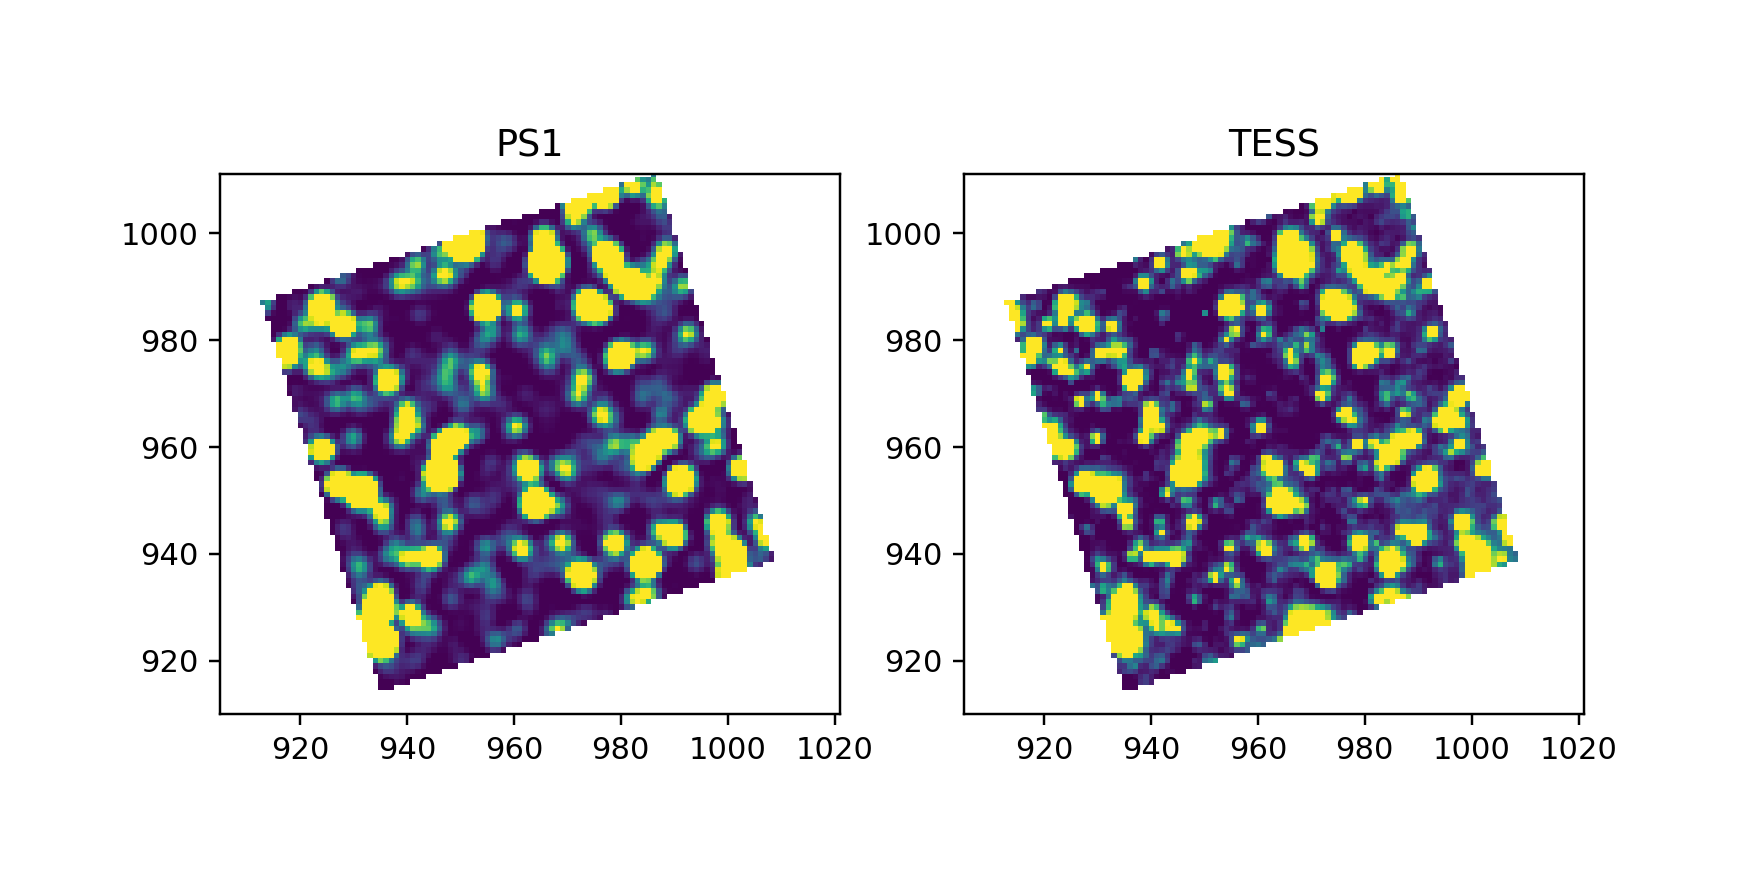

(910.0, 1011.0)

In [65]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PS1')
vmin = np.nanpercentile(s,16)
vmax = np.nanpercentile(s,84)
plt.imshow(s,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.xlim(1020,1120)
#plt.ylim(1015,1115)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)
plt.subplot(122)
plt.title('TESS')
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)

In [62]:
ind = np.where(ps1_assignment == assigned_tess[1])
ps1_tess[ind[0],ind[1]]

array([0.8400738 , 0.76334559, 0.80271631, ..., 1.63023859, 1.67886581,
       1.7281307 ])

In [63]:
ps1_assignment[ps1_assignment]

IndexError: index 2109145 is out of bounds for axis 0 with size 6289

In [ ]:
plt.figure()
plt.imshow(ps1_tess)

<IPython.core.display.Javascript object>


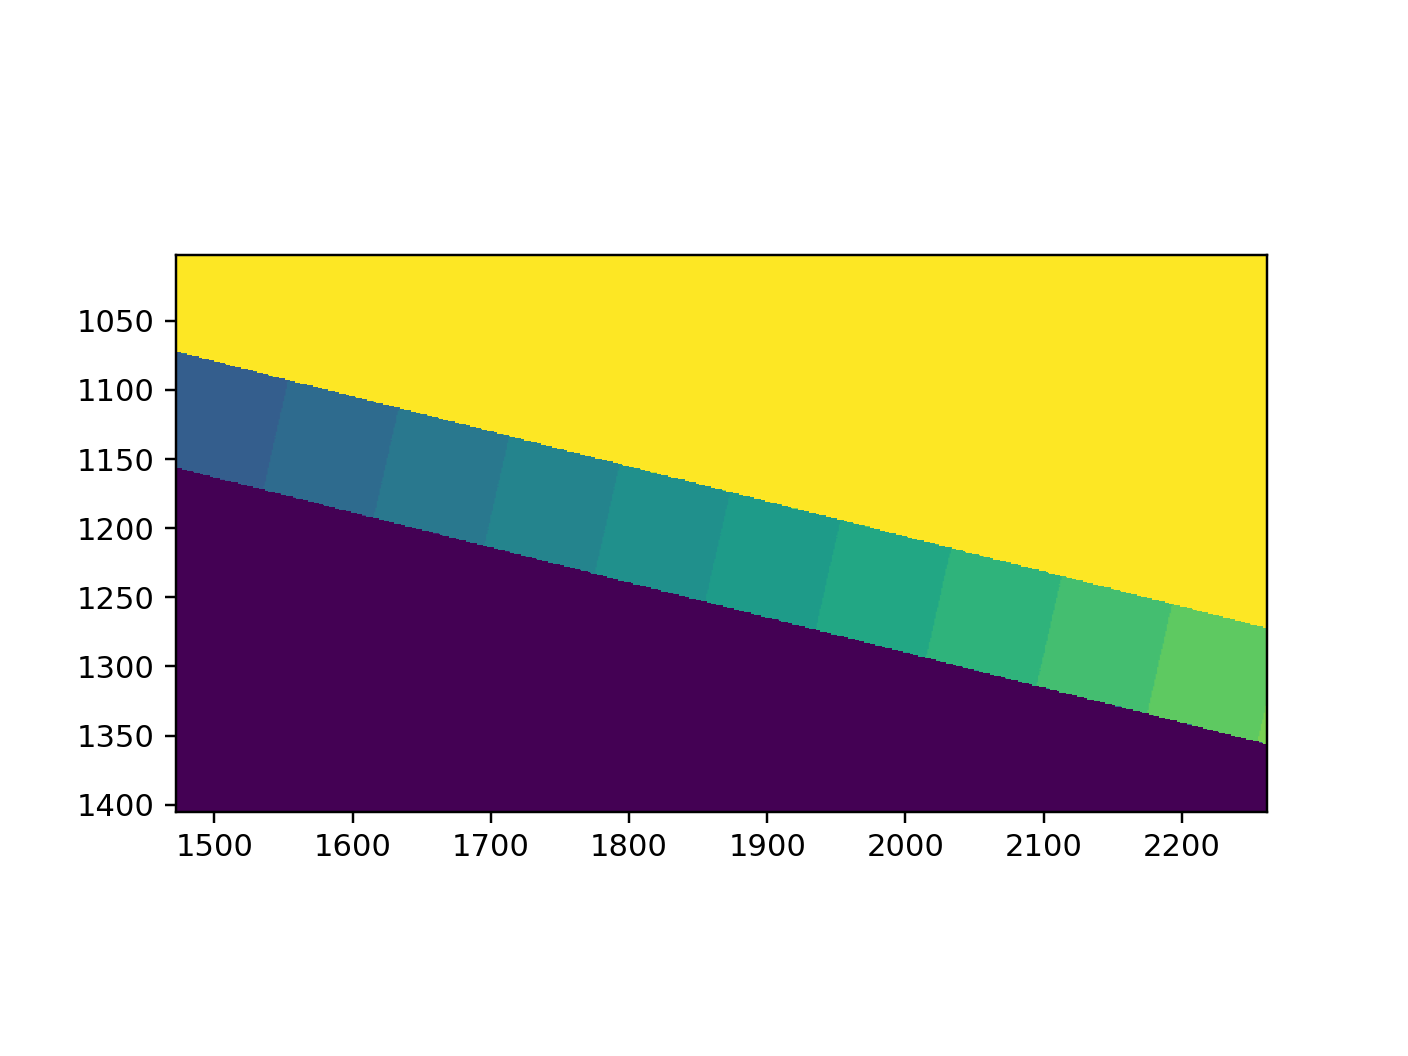

In [27]:
plt.figure()
plt.imshow(ps1_assignment,vmin = ps1_assignment[1000,1000],vmax = ps1_assignment[1000,1000]+20)